# MODEL TUNING

## Objectives



*   Create a data frame with change in indoor temperature.
*   Determine target as change value in temperature.
*   Determine predictors as 5 minutes' data points.
*   Apply different regression models to determine the best.
*   Model tuning

      * Predict 5 minute into the future with differencing.
      * Predict 1 minute into the future.
      * Predict 10 minutes into the future.
      * Predict 5 minutes into the future with 10 minutes's predictors.


#IMPORT DATA

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style('darkgrid') 
font = {'weight' : 'bold', 'size' : 23}
matplotlib.rc('font', **font)
plt.style.use('seaborn')

pd.set_option('display.max_columns',0)

from sklearn import metrics
from sklearn.metrics import mean_squared_error


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor


from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor


import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('/content/thermostat_df.csv')
df['ts'] = pd.to_datetime(df['ts'])
ts = df.set_index('ts')
ts.index = pd.to_datetime(ts.index, unit='s')
ts.head(15)

,building_id,outdoor_temp,boiler_on,indoor_temp
ts,,,,
2020-11-17 20:24:00,6294,46.748,0.0,76.6015
2020-11-17 20:25:00,6294,46.798,0.0,76.6015
2020-11-17 20:26:00,6294,46.810,0.0,76.6015
2020-11-17 20:27:00,6294,46.636,0.0,76.6015
2020-11-17 20:28:00,6294,46.224,0.0,76.6015
2020-11-17 20:29:00,6294,46.362,0.0,76.6015
2020-11-17 20:30:00,6294,46.586,0.0,76.6015
2020-11-17 20:31:00,6294,46.437,0.0,76.5455
2020-11-17 20:32:00,6294,46.337,0.0,76.5455


In [3]:
ts.drop('building_id', axis=1, inplace=True)

In [4]:
ts.dropna(inplace=True)

In [5]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049378 entries, 2020-11-17 20:24:00 to 2020-12-17 20:21:00
Data columns (total 3 columns):
 #   Column        Dtype  
---  ------        -----  
 0   outdoor_temp  float64
 1   boiler_on     float64
 2   indoor_temp   float64
dtypes: float64(3)
memory usage: 62.5 MB


In [6]:
len(df)

2049378

# MODELING DATA

## Functions

In [7]:
def plot_feature_importances(model, X):
    
    """
    Function to plot regression model's feature importances.
    This model must be fitted to the X and y.

    ----------
    
    Args:
        model: The regression model fitted to the data.
        X: Model predictors.
    
    Returns:
        A vertical bar plot with the predictors in the model
        and their feature importance value calculated by
        ensemble methods .feature_importance method.
    
    """
    
    n_features = X.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values, fontsize=13) 
    plt.xlabel('Feature importance', fontsize=16)
    plt.ylabel('Features', fontsize=16)
    plt.title('Feature Importance Plot', fontsize=20)

In [8]:
def feature_importance_df(model, X):
    """
    Function to create a pandas feature importance dataframe and plot a bar graph.

    -----------

    Args:
      model: Pipeline model name.
      X: Predictor dataframe. It is used for predictor column names in the model.
    Returns:
      Descending feature importance dataframe as features are indices.
      Feature importances bar plot.

    """
    coefs = pd.DataFrame(
               model.named_steps['m'].feature_importances_,
               columns=['Feature_Importances'], index=X.columns
               )
    coefs['Feature_Importances'] = round(coefs['Feature_Importances'],5)
    coefs = coefs.sort_values(by='Feature_Importances', ascending=False)

    fig = plt.figure(figsize=(18,8))
    ax1 = fig.add_subplot(121)
    ax1.barh(y=coefs.index, width=coefs['Feature_Importances'])
    ax1.set_title('Feature Importances', fontsize=14)

    ax2 = fig.add_subplot(122)
    font_size=12
    bbox=[0, 0, 1, 1]
    ax2.axis('off')
    mpl_table = ax2.table(cellText = coefs.values, rowLabels = coefs.index, bbox=bbox, colLabels=coefs.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    plt.tight_layout()

In [9]:
def regression_modeling(regressor, scaler, name):

    """
    Function to apply a regression model with a pipeline.
     
      - Pipeline is created with the regressor and scaler.
      - Pipeline is fit to X_train and y_train.
      - Prediction is created for X_test.

    ----------

    Args:
      regressor : Initiated regression method.
      scaler    : Initiated standardization method.
      name      : Name of the regression model.

    Returns:
      - Print train and test scores.
      - Print mean squared error value.
      - Returns feature_importance_df function refults.
          * A feature importance dataframe and a bar plot.    
    """
    
    pipeline = Pipeline([('ss', scaler),
                         ('m', regressor)])
    
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    print('Train Score : ', round(pipeline.score(X_train, y_train),5))
    print('Test Score  : ', round(pipeline.score(X_test, y_test),5), '\n')

    mse = round(mean_squared_error(y_test, y_pred),5)
    print(name+' Mean Squared Error : ', mse)
    print('\n\n')

    feature_importance_df(pipeline, X_train)

## Predictors and Target

In [10]:
# Create a shift columns with the next 5th minute's indoor temperature.
temp = ts[['indoor_temp']]
ts_shift = temp.shift(periods=-5)
ts_shift = ts_shift.rename(columns={'indoor_temp':'shifted_temp'})

In [11]:
ts_new = pd.concat([ts, ts_shift], axis=1)
ts_new.dropna(inplace=True)
ts_new.head()

,outdoor_temp,boiler_on,indoor_temp,shifted_temp
ts,,,,
2020-11-17 20:24:00,46.748,0.0,76.6015,76.6015
2020-11-17 20:25:00,46.798,0.0,76.6015,76.6015
2020-11-17 20:26:00,46.810,0.0,76.6015,76.5455
2020-11-17 20:27:00,46.636,0.0,76.6015,76.5455
2020-11-17 20:28:00,46.224,0.0,76.6015,76.5455


Create an indoor temperature difference column by subtracting indoor temperature from shifted indoor temperature. This will be our target that we will predict. In this model, we use dataset where there is an indoor temperature change.

In [12]:
# Create an indoor temperature difference column by subtracting indoor temperature
# from shifted indoor temperature.
ts_new['temp_diff'] = ts_new['shifted_temp'] - ts_new['indoor_temp']
ts_new.head(20)

,outdoor_temp,boiler_on,indoor_temp,shifted_temp,temp_diff
ts,,,,,
2020-11-17 20:24:00,46.748,0.0,76.6015,76.6015,0.0000
2020-11-17 20:25:00,46.798,0.0,76.6015,76.6015,0.0000
2020-11-17 20:26:00,46.810,0.0,76.6015,76.5455,-0.0560
2020-11-17 20:27:00,46.636,0.0,76.6015,76.5455,-0.0560
2020-11-17 20:28:00,46.224,0.0,76.6015,76.5455,-0.0560
2020-11-17 20:29:00,46.362,0.0,76.6015,76.5455,-0.0560
2020-11-17 20:30:00,46.586,0.0,76.6015,76.5455,-0.0560
2020-11-17 20:31:00,46.437,0.0,76.5455,76.5455,0.0000
2020-11-17 20:32:00,46.337,0.0,76.5455,76.5455,0.0000


In [13]:
print('The number of the data where the indoor temperature change is zero:')
len(ts_new[ts_new['temp_diff']==0])

The number of the data where the indoor temperature change is zero:


1108439

In [14]:
round(ts_new.describe(),3)

,outdoor_temp,boiler_on,indoor_temp,shifted_temp,temp_diff
count,2049373.000,2049373.000,2049373.000,2049373.000,2049373.000
mean,47.102,0.260,72.720,72.720,-0.000
std,21.748,0.439,2.307,2.307,0.309
min,-94.139,0.000,55.062,55.062,-17.221
25%,40.367,0.000,71.262,71.262,-0.056
50%,48.208,0.000,72.680,72.680,0.000
75%,55.700,1.000,74.187,74.187,0.000
max,123.358,1.000,84.875,84.875,21.825


In [15]:
# Create a dataframe where the indoor temperature change after 5 minutes is not 0.
ts_diff = ts_new[ts_new['temp_diff'] != 0]

In [16]:
print('The number of the data where the indoor temperature change is not zero:')
len(ts_diff)

The number of the data where the indoor temperature change is not zero:


940934

In [17]:
round(ts_diff.describe(),3)

,outdoor_temp,boiler_on,indoor_temp,shifted_temp,temp_diff
count,940934.000,940934.000,940934.000,940934.000,940934.000
mean,44.448,0.298,72.859,72.859,-0.000
std,24.080,0.457,2.265,2.265,0.455
min,-94.139,0.000,55.062,55.062,-17.221
25%,39.105,0.000,71.375,71.375,-0.113
50%,46.487,0.000,72.725,72.725,-0.056
75%,53.646,1.000,74.300,74.300,0.113
max,123.358,1.000,84.875,84.875,21.825


***Observations***

*   We observe that for more than half of the data there is no indoor temperature change within the next 5th minute. 

*   We also see a slight increase in indoor temperature's mean value and standard deviation.


 

In [18]:
columns = ['indoor_temp', 'outdoor_temp', 'boiler_on']

# Create predictors dataset with previous 4 minutes' data
for col in columns:
    for i in range(1,5):
        ts_diff[col+str(i)+'_min_ago'] = ts_diff[col].shift(i)

ts_diff.dropna(inplace=True)
ts_diff.head(10)

,outdoor_temp,boiler_on,indoor_temp,shifted_temp,temp_diff,indoor_temp1_min_ago,indoor_temp2_min_ago,indoor_temp3_min_ago,indoor_temp4_min_ago,outdoor_temp1_min_ago,outdoor_temp2_min_ago,outdoor_temp3_min_ago,outdoor_temp4_min_ago,boiler_on1_min_ago,boiler_on2_min_ago,boiler_on3_min_ago,boiler_on4_min_ago
ts,,,,,,,,,,,,,,,,,
2020-11-17 20:30:00,46.586,0.0,76.6015,76.5455,-0.0560,76.6015,76.6015,76.6015,76.6015,46.362,46.224,46.636,46.810,0.0,0.0,0.0,0.0
2020-11-17 20:40:00,46.860,0.0,76.5455,74.9750,-1.5705,76.6015,76.6015,76.6015,76.6015,46.586,46.362,46.224,46.636,0.0,0.0,0.0,0.0
2020-11-17 20:41:00,46.760,0.0,76.5455,74.9750,-1.5705,76.5455,76.6015,76.6015,76.6015,46.860,46.586,46.362,46.224,0.0,0.0,0.0,0.0
2020-11-17 20:42:00,46.872,0.0,76.5455,74.9750,-1.5705,76.5455,76.5455,76.6015,76.6015,46.760,46.860,46.586,46.362,0.0,0.0,0.0,0.0
2020-11-17 20:43:00,46.884,0.0,76.5455,74.9750,-1.5705,76.5455,76.5455,76.5455,76.6015,46.872,46.760,46.860,46.586,0.0,0.0,0.0,0.0
2020-11-17 20:44:00,46.835,0.0,76.5455,74.9750,-1.5705,76.5455,76.5455,76.5455,76.5455,46.884,46.872,46.760,46.860,0.0,0.0,0.0,0.0
2020-11-17 20:45:00,46.636,0.0,74.9750,74.4125,-0.5625,76.5455,76.5455,76.5455,76.5455,46.835,46.884,46.872,46.760,0.0,0.0,0.0,0.0
2020-11-17 20:46:00,46.424,0.0,74.9750,74.3560,-0.6190,74.9750,76.5455,76.5455,76.5455,46.636,46.835,46.884,46.872,0.0,0.0,0.0,0.0
2020-11-17 20:47:00,46.512,0.0,74.9750,74.3560,-0.6190,74.9750,74.9750,76.5455,76.5455,46.424,46.636,46.835,46.884,0.0,0.0,0.0,0.0


In [19]:
# Create Target
y = ts_diff[['temp_diff']]
y.head()


,temp_diff
ts,
2020-11-17 20:30:00,-0.0560
2020-11-17 20:40:00,-1.5705
2020-11-17 20:41:00,-1.5705
2020-11-17 20:42:00,-1.5705
2020-11-17 20:43:00,-1.5705


In [20]:
# Create predictors
X = ts_diff.drop(['shifted_temp', 'temp_diff'], axis=1)
X.head()

,outdoor_temp,boiler_on,indoor_temp,indoor_temp1_min_ago,indoor_temp2_min_ago,indoor_temp3_min_ago,indoor_temp4_min_ago,outdoor_temp1_min_ago,outdoor_temp2_min_ago,outdoor_temp3_min_ago,outdoor_temp4_min_ago,boiler_on1_min_ago,boiler_on2_min_ago,boiler_on3_min_ago,boiler_on4_min_ago
ts,,,,,,,,,,,,,,,
2020-11-17 20:30:00,46.586,0.0,76.6015,76.6015,76.6015,76.6015,76.6015,46.362,46.224,46.636,46.810,0.0,0.0,0.0,0.0
2020-11-17 20:40:00,46.860,0.0,76.5455,76.6015,76.6015,76.6015,76.6015,46.586,46.362,46.224,46.636,0.0,0.0,0.0,0.0
2020-11-17 20:41:00,46.760,0.0,76.5455,76.5455,76.6015,76.6015,76.6015,46.860,46.586,46.362,46.224,0.0,0.0,0.0,0.0
2020-11-17 20:42:00,46.872,0.0,76.5455,76.5455,76.5455,76.6015,76.6015,46.760,46.860,46.586,46.362,0.0,0.0,0.0,0.0
2020-11-17 20:43:00,46.884,0.0,76.5455,76.5455,76.5455,76.5455,76.6015,46.872,46.760,46.860,46.586,0.0,0.0,0.0,0.0


## Train Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(658651, 15) (282279, 15) (658651, 1) (282279, 1)


# MODELING

## Decision Tree Regressor

Train Score :  0.99999
Test Score  :  -0.1541 

Decision Tree Regression Mean Squared Error :  0.24454





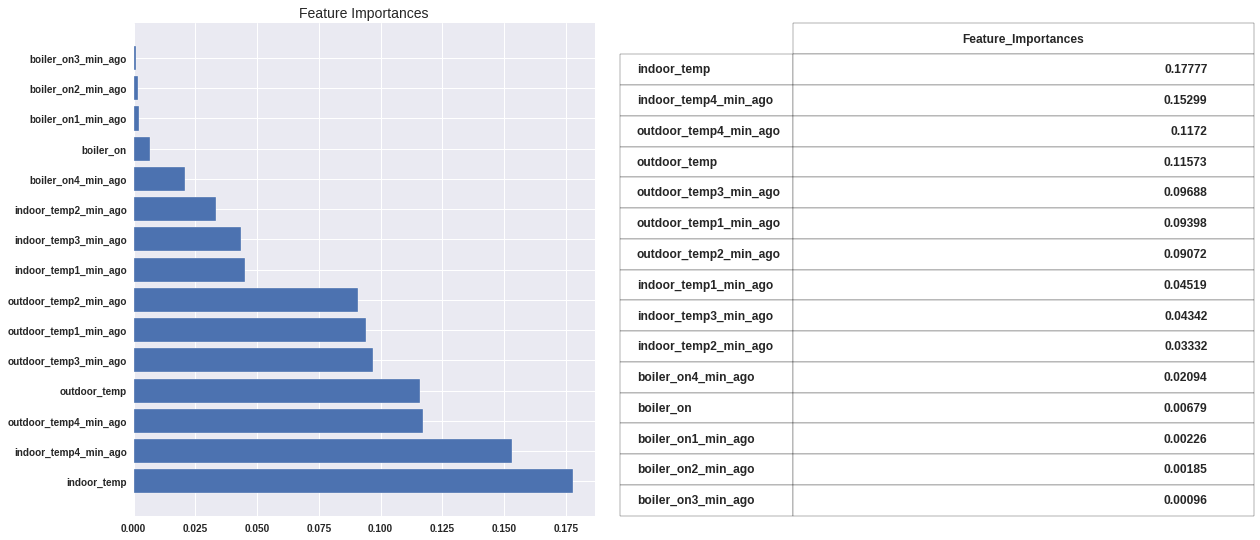

In [41]:
dtr_reg = DecisionTreeRegressor(criterion='mse',
                                random_state=123)
scaler = StandardScaler()

regression_modeling(dtr_reg, scaler, 'Decision Tree Regression')

### ***Observations***

*   In the Model Aplication Notebook, we calculated MSE for the entire dataset as 0.067, using Extra Trees Regressor.

*   Decision Tree Regression MSE for the entire data set is 0.24454.

*   Top 3 predictors are:

      * Indoor Temperature - 0 Minute Ago
      * Indoor Temperature - 4 Minutes Ago
      * Outdoor Temperature 4 Minutes Ago
      * Outdoor Temperature - 0 Minute Ago
      * Outdoor Temperature 3 Minutes Ago

*   We observe the distribution of feature importance are significantly around indoor and outdoor temperature. Boiler on/off info has the least importance according to this model.



## Extra Trees Regressor

Train Score :  0.99999
Test Score  :  0.37091 

Extra Trees Regression Mean Squared Error :  0.1333





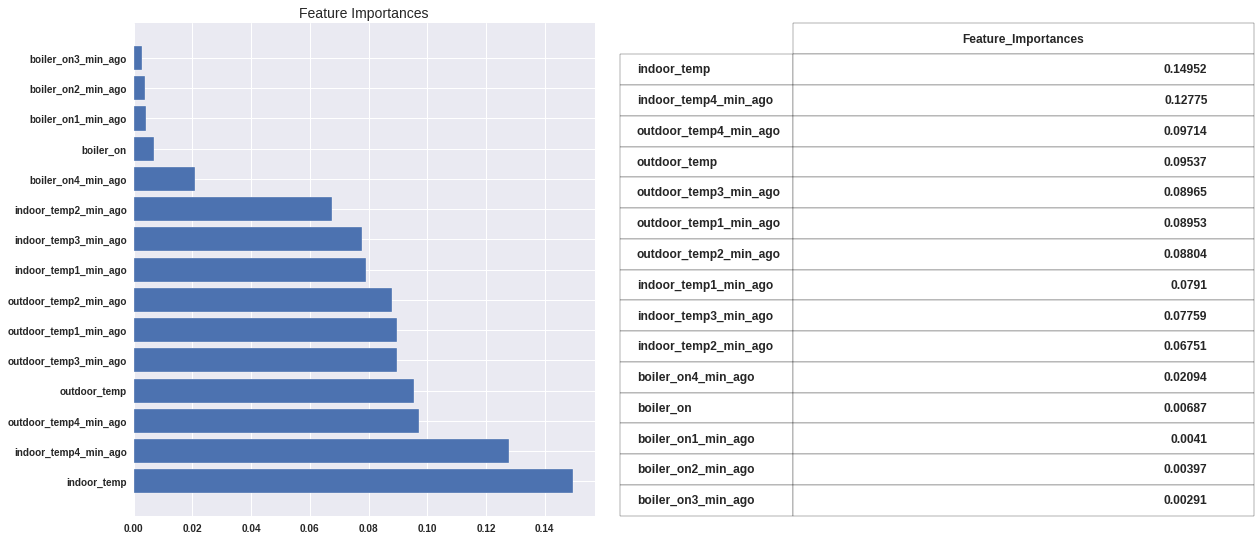

In [42]:
ets_reg = ExtraTreesRegressor(criterion='mse',
                              random_state=123)
scaler = MinMaxScaler()

regression_modeling(ets_reg, scaler, 'Extra Trees Regression')

### ***Observations***

*   Extra Trees Regression MSE for the entire data set is 0.1333.

*   Top 5 predictors are:

      * Indoor Temperature - 0 Minutes Ago
      * Indoor Temperature - 4 Minutes Ago
      * Outdoor Temperature - 4 Minutes Ago
      * Outdoor Temperature - Minute 0
      * Outdoor Temperature - 3 Minutes Ago

*   We observe the distribution of feature importance are significantly around indoor and outdoor temperature. Boiler on/off info has the least importance according to this model.



##Random Forest Regressor

Train Score :  0.9093
Test Score  :  0.35989 

Random Forest Regression Mean Squared Error :  0.13563





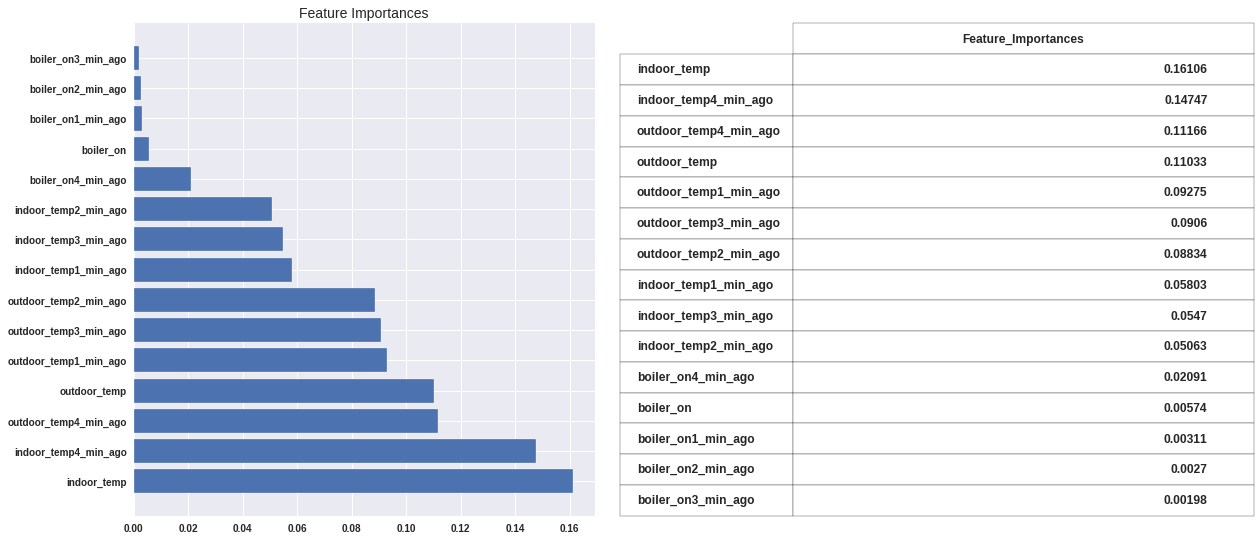

In [43]:
rf_reg = RandomForestRegressor(criterion='mse',
                               random_state=123)
scaler = MinMaxScaler()

regression_modeling(rf_reg, scaler, 'Random Forest Regression')

### ***Observations***

*   Random Forest Regression MSE for the entire data set is 0.13563.

*   Top 5 predictors are:

      * Indoor Temperature - 0 Minutes Ago
      * Indoor Temperature - 4 Minute Ago
      * Outdoor Temperature - 4 Minutes Ago
      * Outdoor Temperature - 0 Minute Ago
      * Outdoor Temperature - 1 Minutes Ago

*   We observe the distribution of feature importance are significantly around indoor and outdoor temperature. Boiler on/off info has the least importance according to this model.

## Conclusion

*   In this section, we created a new target using the difference between the indoor temperature and the indoor tempereture 5 minutes into the future.

*   Our predictors are 5 minutes' value of data including *indoor_temp*, *outdoor_temp* and *boiler_on* columns.

*   Random Forest Regression and Extra Trees Regression provide better MSE values and test scores.

*   We keep tuning the model using Random Forest Regression Model.
      * We tried both Random Forest and Extra Trees Regressions for modeling and we received better results with Random Forest Tuning even though for the base model Extra Trees Regression performs slightly better.

# MODEL TUNING

## Random Forest with Differencing

We apply differencing with periods=5. We also apply diffrencing with perdiod=1. We share the results in observations.

In [44]:
ts = pd.concat([ts[['outdoor_temp', 'indoor_temp']].diff(periods=5), ts[['boiler_on']]], axis=1)
# ts = ts.diff(periods=5)
ts.dropna(inplace=True)
ts.head()

,outdoor_temp,indoor_temp,boiler_on
ts,,,
2020-11-17 20:29:00,-0.386,0.000,0.0
2020-11-17 20:30:00,-0.212,0.000,0.0
2020-11-17 20:31:00,-0.373,-0.056,0.0
2020-11-17 20:32:00,-0.299,-0.056,0.0
2020-11-17 20:33:00,0.412,-0.056,0.0


In [45]:
temp = ts[['indoor_temp']]
ts_shift = temp.shift(periods=-5)
ts_shift = ts_shift.rename(columns={'indoor_temp':'shifted_temp'})

In [46]:
ts_new = pd.concat([ts, ts_shift], axis=1)
ts_new.dropna(inplace=True)
ts_new.head()
ts_new['temp_diff'] = ts_new['shifted_temp'] - ts_new['indoor_temp']
ts_new.head(10)

,outdoor_temp,indoor_temp,boiler_on,shifted_temp,temp_diff
ts,,,,,
2020-11-17 20:29:00,-0.386,0.000,0.0,-0.056,-0.056
2020-11-17 20:30:00,-0.212,0.000,0.0,-0.056,-0.056
2020-11-17 20:31:00,-0.373,-0.056,0.0,0.000,0.056
2020-11-17 20:32:00,-0.299,-0.056,0.0,0.000,0.056
2020-11-17 20:33:00,0.412,-0.056,0.0,0.000,0.056
2020-11-17 20:34:00,0.460,-0.056,0.0,0.000,0.056
2020-11-17 20:35:00,0.174,-0.056,0.0,0.000,0.056
2020-11-17 20:36:00,0.286,0.000,0.0,0.000,0.000
2020-11-17 20:37:00,0.399,0.000,0.0,0.000,0.000


In [51]:
ts_diff = ts_new[ts_new['temp_diff'] != 0]
ts_diff.head(10)

,outdoor_temp,indoor_temp,boiler_on,shifted_temp,temp_diff
ts,,,,,
2020-11-17 20:29:00,-0.386,0.000,0.0,-0.0560,-0.0560
2020-11-17 20:30:00,-0.212,0.000,0.0,-0.0560,-0.0560
2020-11-17 20:31:00,-0.373,-0.056,0.0,0.0000,0.0560
2020-11-17 20:32:00,-0.299,-0.056,0.0,0.0000,0.0560
2020-11-17 20:33:00,0.412,-0.056,0.0,0.0000,0.0560
2020-11-17 20:34:00,0.460,-0.056,0.0,0.0000,0.0560
2020-11-17 20:35:00,0.174,-0.056,0.0,0.0000,0.0560
2020-11-17 20:40:00,0.100,0.000,0.0,-1.5705,-1.5705
2020-11-17 20:41:00,0.037,0.000,0.0,-1.5705,-1.5705


In [53]:
columns = ['indoor_temp', 'outdoor_temp', 'boiler_on']

for col in columns:
    for i in range(1,5):
        ts_diff[col+str(i)+'_min_ago'] = ts_diff[col].shift(i)

In [59]:
ts_diff.dropna(inplace=True)
ts_diff.head()

,outdoor_temp,indoor_temp,boiler_on,shifted_temp,temp_diff,indoor_temp1_min_ago,indoor_temp2_min_ago,indoor_temp3_min_ago,indoor_temp4_min_ago,outdoor_temp1_min_ago,outdoor_temp2_min_ago,outdoor_temp3_min_ago,outdoor_temp4_min_ago,boiler_on1_min_ago,boiler_on2_min_ago,boiler_on3_min_ago,boiler_on4_min_ago
ts,,,,,,,,,,,,,,,,,
2020-11-17 20:33:00,0.412,-0.056,0.0,0.0000,0.0560,-0.056,-0.056,0.000,0.000,-0.299,-0.373,-0.212,-0.386,0.0,0.0,0.0,0.0
2020-11-17 20:34:00,0.460,-0.056,0.0,0.0000,0.0560,-0.056,-0.056,-0.056,0.000,0.412,-0.299,-0.373,-0.212,0.0,0.0,0.0,0.0
2020-11-17 20:35:00,0.174,-0.056,0.0,0.0000,0.0560,-0.056,-0.056,-0.056,-0.056,0.460,0.412,-0.299,-0.373,0.0,0.0,0.0,0.0
2020-11-17 20:40:00,0.100,0.000,0.0,-1.5705,-1.5705,-0.056,-0.056,-0.056,-0.056,0.174,0.460,0.412,-0.299,0.0,0.0,0.0,0.0
2020-11-17 20:41:00,0.037,0.000,0.0,-1.5705,-1.5705,0.000,-0.056,-0.056,-0.056,0.100,0.174,0.460,0.412,0.0,0.0,0.0,0.0


In [60]:
# Creating Target
y = ts_diff[['temp_diff']]
y.head()

,temp_diff
ts,
2020-11-17 20:33:00,0.0560
2020-11-17 20:34:00,0.0560
2020-11-17 20:35:00,0.0560
2020-11-17 20:40:00,-1.5705
2020-11-17 20:41:00,-1.5705


In [61]:
X = ts_diff.drop(['shifted_temp', 'temp_diff'], axis=1)
X.head()

,outdoor_temp,indoor_temp,boiler_on,indoor_temp1_min_ago,indoor_temp2_min_ago,indoor_temp3_min_ago,indoor_temp4_min_ago,outdoor_temp1_min_ago,outdoor_temp2_min_ago,outdoor_temp3_min_ago,outdoor_temp4_min_ago,boiler_on1_min_ago,boiler_on2_min_ago,boiler_on3_min_ago,boiler_on4_min_ago
ts,,,,,,,,,,,,,,,
2020-11-17 20:33:00,0.412,-0.056,0.0,-0.056,-0.056,0.000,0.000,-0.299,-0.373,-0.212,-0.386,0.0,0.0,0.0,0.0
2020-11-17 20:34:00,0.460,-0.056,0.0,-0.056,-0.056,-0.056,0.000,0.412,-0.299,-0.373,-0.212,0.0,0.0,0.0,0.0
2020-11-17 20:35:00,0.174,-0.056,0.0,-0.056,-0.056,-0.056,-0.056,0.460,0.412,-0.299,-0.373,0.0,0.0,0.0,0.0
2020-11-17 20:40:00,0.100,0.000,0.0,-0.056,-0.056,-0.056,-0.056,0.174,0.460,0.412,-0.299,0.0,0.0,0.0,0.0
2020-11-17 20:41:00,0.037,0.000,0.0,0.000,-0.056,-0.056,-0.056,0.100,0.174,0.460,0.412,0.0,0.0,0.0,0.0


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(932854, 15) (399795, 15) (932854, 1) (399795, 1)


In [ ]:
rf_reg = RandomForestRegressor(criterion='mse',
                               random_state=123)
scaler = MinMaxScaler()

regression_modeling(rf_reg, scaler, 'Random Forest Regression')

### ***Observations***

*   We created a dataset using differencing with period 1 and period 5.

*   We applied Random Forest Regression with MinMaxScaler.

*   The MSE for period=1 differencing is 0.12005. (Train Score = 0.93, Test Score = 0.529)

*   The MSE for period=5 differencing is 0.12897 with higher Train and Test Score. (Train Score = 0.945, Test Score = 0.622)

*   The model heavily relies on 4 minutes ago indoor temperature.

## Predicting 1 Minute Out

In [31]:
ts = pd.concat([ts[['outdoor_temp', 'indoor_temp']].diff(periods=1), ts[['boiler_on']]], axis=1)
ts.dropna(inplace=True)

In [32]:
temp = ts[['indoor_temp']]
ts_shift = temp.shift(periods=-1)
ts_shift = ts_shift.rename(columns={'indoor_temp':'shifted_temp'})

ts_new = pd.concat([ts, ts_shift], axis=1)
ts_new.dropna(inplace=True)
ts_new.head()
ts_new['temp_diff'] = ts_new['shifted_temp'] - ts_new['indoor_temp']

ts_diff = ts_new[ts_new['temp_diff'] != 0]
ts_diff.head(10)

,outdoor_temp,indoor_temp,boiler_on,shifted_temp,temp_diff
ts,,,,,
2020-11-17 20:30:00,-0.464,0.0000,0.0,-0.0560,-0.0560
2020-11-17 20:31:00,-0.459,-0.0560,0.0,0.1120,0.1680
2020-11-17 20:32:00,0.422,0.1120,0.0,-0.0560,-0.1680
2020-11-17 20:33:00,0.350,-0.0560,0.0,0.0000,0.0560
2020-11-17 20:44:00,0.039,0.0000,0.0,-1.5705,-1.5705
2020-11-17 20:45:00,-0.089,-1.5705,0.0,3.1410,4.7115
2020-11-17 20:46:00,0.137,3.1410,0.0,-1.5705,-4.7115
2020-11-17 20:47:00,0.313,-1.5705,0.0,0.0000,1.5705
2020-11-17 20:49:00,0.125,0.0000,0.0,-0.5625,-0.5625


In [33]:
columns = ['indoor_temp', 'outdoor_temp', 'boiler_on']

for col in columns:
    for i in range(1,5):
        ts_diff[col+str(i)+'_min_ago'] = ts_diff[col].shift(i)
ts_diff.dropna(inplace=True)
ts_diff.head()

,outdoor_temp,indoor_temp,boiler_on,shifted_temp,temp_diff,indoor_temp1_min_ago,indoor_temp2_min_ago,indoor_temp3_min_ago,indoor_temp4_min_ago,outdoor_temp1_min_ago,outdoor_temp2_min_ago,outdoor_temp3_min_ago,outdoor_temp4_min_ago,boiler_on1_min_ago,boiler_on2_min_ago,boiler_on3_min_ago,boiler_on4_min_ago
ts,,,,,,,,,,,,,,,,,
2020-11-17 20:44:00,0.039,0.0000,0.0,-1.5705,-1.5705,-0.0560,0.1120,-0.0560,0.000,0.350,0.422,-0.459,-0.464,0.0,0.0,0.0,0.0
2020-11-17 20:45:00,-0.089,-1.5705,0.0,3.1410,4.7115,0.0000,-0.0560,0.1120,-0.056,0.039,0.350,0.422,-0.459,0.0,0.0,0.0,0.0
2020-11-17 20:46:00,0.137,3.1410,0.0,-1.5705,-4.7115,-1.5705,0.0000,-0.0560,0.112,-0.089,0.039,0.350,0.422,0.0,0.0,0.0,0.0
2020-11-17 20:47:00,0.313,-1.5705,0.0,0.0000,1.5705,3.1410,-1.5705,0.0000,-0.056,0.137,-0.089,0.039,0.350,0.0,0.0,0.0,0.0
2020-11-17 20:49:00,0.125,0.0000,0.0,-0.5625,-0.5625,-1.5705,3.1410,-1.5705,0.000,0.313,0.137,-0.089,0.039,0.0,0.0,0.0,0.0


In [34]:
# Creating target
y = ts_diff[['temp_diff']]
y.head()

,temp_diff
ts,
2020-11-17 20:44:00,-1.5705
2020-11-17 20:45:00,4.7115
2020-11-17 20:46:00,-4.7115
2020-11-17 20:47:00,1.5705
2020-11-17 20:49:00,-0.5625


In [35]:
# Create predictors
X = ts_diff.drop(['shifted_temp', 'temp_diff'], axis=1)
X.head()

,outdoor_temp,indoor_temp,boiler_on,indoor_temp1_min_ago,indoor_temp2_min_ago,indoor_temp3_min_ago,indoor_temp4_min_ago,outdoor_temp1_min_ago,outdoor_temp2_min_ago,outdoor_temp3_min_ago,outdoor_temp4_min_ago,boiler_on1_min_ago,boiler_on2_min_ago,boiler_on3_min_ago,boiler_on4_min_ago
ts,,,,,,,,,,,,,,,
2020-11-17 20:44:00,0.039,0.0000,0.0,-0.0560,0.1120,-0.0560,0.000,0.350,0.422,-0.459,-0.464,0.0,0.0,0.0,0.0
2020-11-17 20:45:00,-0.089,-1.5705,0.0,0.0000,-0.0560,0.1120,-0.056,0.039,0.350,0.422,-0.459,0.0,0.0,0.0,0.0
2020-11-17 20:46:00,0.137,3.1410,0.0,-1.5705,0.0000,-0.0560,0.112,-0.089,0.039,0.350,0.422,0.0,0.0,0.0,0.0
2020-11-17 20:47:00,0.313,-1.5705,0.0,3.1410,-1.5705,0.0000,-0.056,0.137,-0.089,0.039,0.350,0.0,0.0,0.0,0.0
2020-11-17 20:49:00,0.125,0.0000,0.0,-1.5705,3.1410,-1.5705,0.000,0.313,0.137,-0.089,0.039,0.0,0.0,0.0,0.0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(560654, 15) (240281, 15) (560654, 1) (240281, 1)


Train Score :  0.99051
Test Score  :  0.93144 

Random Forest Regressor - 1 Minute - Mean Squared Error :  0.08476





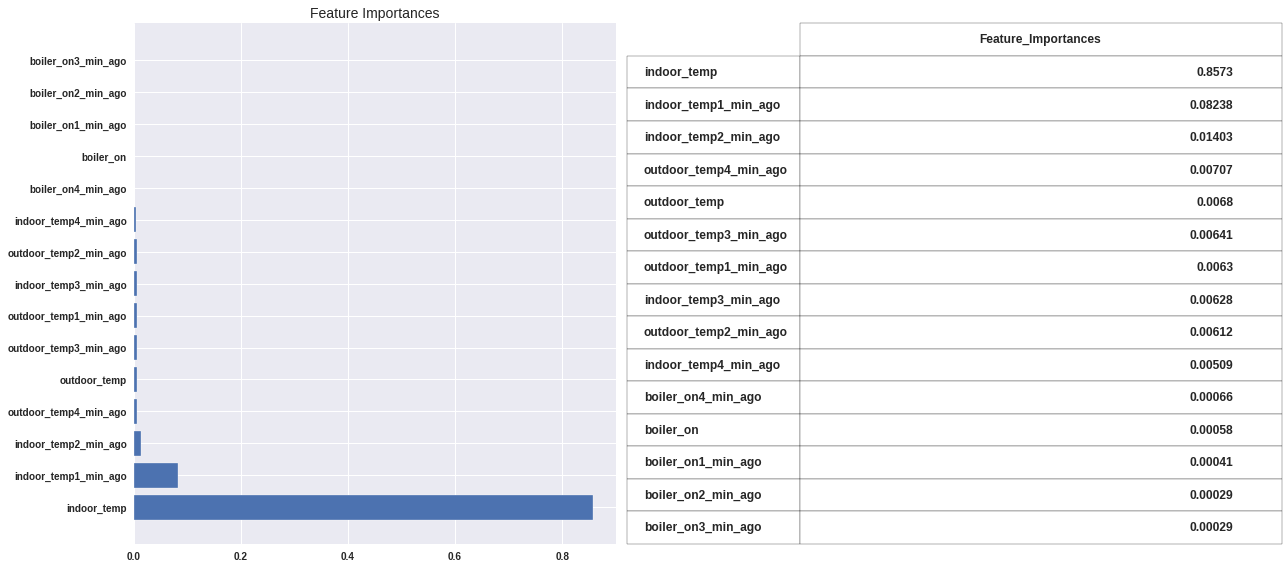

In [37]:
rf_reg_1min = RandomForestRegressor(criterion='mse',
                               random_state=123)
scaler = MinMaxScaler()

regression_modeling(rf_reg_1min, scaler, 'Random Forest Regressor - 1 Minute -')

### ***Observations***


*   We create a new dataset using differencing with period 1.

*   We apply Random Forest Regressor with MinMaxScaler.

*   The MSE of this model is 0.085.

*   It is safe to say our model is doing a good job when predicting the difference between the next minute compared to predicting 5 minutes into the future.








## Predicting 10 Minute Out

In [38]:
ts = pd.concat([ts[['outdoor_temp', 'indoor_temp']].diff(periods=1), ts[['boiler_on']]], axis=1)
ts.dropna(inplace=True)

In [7]:
temp = ts[['indoor_temp']]
ts_shift = temp.shift(periods=-10)
ts_shift = ts_shift.rename(columns={'indoor_temp':'shifted_temp'})

ts_new = pd.concat([ts, ts_shift], axis=1)
ts_new.dropna(inplace=True)
ts_new.head()
ts_new['temp_diff'] = ts_new['shifted_temp'] - ts_new['indoor_temp']

ts_diff = ts_new[ts_new['temp_diff'] != 0]
ts_diff.head(10)

,outdoor_temp,indoor_temp,boiler_on,shifted_temp,temp_diff
ts,,,,,
2020-11-17 20:31:00,-0.149,-0.0560,0.0,0.0000,0.0560
2020-11-17 20:36:00,-0.037,0.0000,0.0,-0.0560,-0.0560
2020-11-17 20:45:00,-0.199,-1.5705,0.0,0.0000,1.5705
2020-11-17 20:50:00,-0.100,-0.5625,0.0,-1.5705,-1.0080
2020-11-17 20:51:00,-0.062,-0.0565,0.0,0.0000,0.0565
2020-11-17 20:55:00,-0.100,0.0000,0.0,-0.5625,-0.5625
2020-11-17 20:56:00,-0.101,0.0000,0.0,-0.0565,-0.0565
2020-11-17 21:05:00,0.013,0.1685,1.0,0.0000,-0.1685
2020-11-17 21:06:00,-0.013,-0.0560,1.0,0.0000,0.0560


In [39]:
columns = ['indoor_temp', 'outdoor_temp', 'boiler_on']

for col in columns:
    for i in range(1,5):
        ts_diff[col+str(i)+'_min_ago'] = ts_diff[col].shift(i)
ts_diff.dropna(inplace=True)
ts_diff.head()

,outdoor_temp,indoor_temp,boiler_on,shifted_temp,temp_diff,indoor_temp1_min_ago,indoor_temp2_min_ago,indoor_temp3_min_ago,indoor_temp4_min_ago,outdoor_temp1_min_ago,outdoor_temp2_min_ago,outdoor_temp3_min_ago,outdoor_temp4_min_ago,boiler_on1_min_ago,boiler_on2_min_ago,boiler_on3_min_ago,boiler_on4_min_ago
ts,,,,,,,,,,,,,,,,,
2020-11-17 20:49:00,0.125,0.0000,0.0,-0.5625,-0.5625,-1.5705,3.1410,-1.5705,0.0000,0.313,0.137,-0.089,0.039,0.0,0.0,0.0,0.0
2020-11-17 20:50:00,-0.174,-0.5625,0.0,1.0685,1.6310,0.0000,-1.5705,3.1410,-1.5705,0.125,0.313,0.137,-0.089,0.0,0.0,0.0,0.0
2020-11-17 20:51:00,0.175,1.0685,0.0,-0.4495,-1.5180,-0.5625,0.0000,-1.5705,3.1410,-0.174,0.125,0.313,0.137,0.0,0.0,0.0,0.0
2020-11-17 20:52:00,-0.151,-0.4495,0.0,-0.0565,0.3930,1.0685,-0.5625,0.0000,-1.5705,0.175,-0.174,0.125,0.313,0.0,0.0,0.0,0.0
2020-11-17 20:53:00,0.275,-0.0565,0.0,0.0000,0.0565,-0.4495,1.0685,-0.5625,0.0000,-0.151,0.175,-0.174,0.125,0.0,0.0,0.0,0.0


In [40]:
# Create target
y = ts_diff[['temp_diff']]

# Create predictors
X = ts_diff.drop(['shifted_temp', 'temp_diff'], axis=1)
X.head()

,outdoor_temp,indoor_temp,boiler_on,indoor_temp1_min_ago,indoor_temp2_min_ago,indoor_temp3_min_ago,indoor_temp4_min_ago,outdoor_temp1_min_ago,outdoor_temp2_min_ago,outdoor_temp3_min_ago,outdoor_temp4_min_ago,boiler_on1_min_ago,boiler_on2_min_ago,boiler_on3_min_ago,boiler_on4_min_ago
ts,,,,,,,,,,,,,,,
2020-11-17 20:49:00,0.125,0.0000,0.0,-1.5705,3.1410,-1.5705,0.0000,0.313,0.137,-0.089,0.039,0.0,0.0,0.0,0.0
2020-11-17 20:50:00,-0.174,-0.5625,0.0,0.0000,-1.5705,3.1410,-1.5705,0.125,0.313,0.137,-0.089,0.0,0.0,0.0,0.0
2020-11-17 20:51:00,0.175,1.0685,0.0,-0.5625,0.0000,-1.5705,3.1410,-0.174,0.125,0.313,0.137,0.0,0.0,0.0,0.0
2020-11-17 20:52:00,-0.151,-0.4495,0.0,1.0685,-0.5625,0.0000,-1.5705,0.175,-0.174,0.125,0.313,0.0,0.0,0.0,0.0
2020-11-17 20:53:00,0.275,-0.0565,0.0,-0.4495,1.0685,-0.5625,0.0000,-0.151,0.175,-0.174,0.125,0.0,0.0,0.0,0.0


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(560651, 15) (240280, 15) (560651, 1) (240280, 1)


Train Score :  0.99103
Test Score  :  0.92613 

Random Forest Regression - 10 Minutes - Mean Squared Error :  0.09053





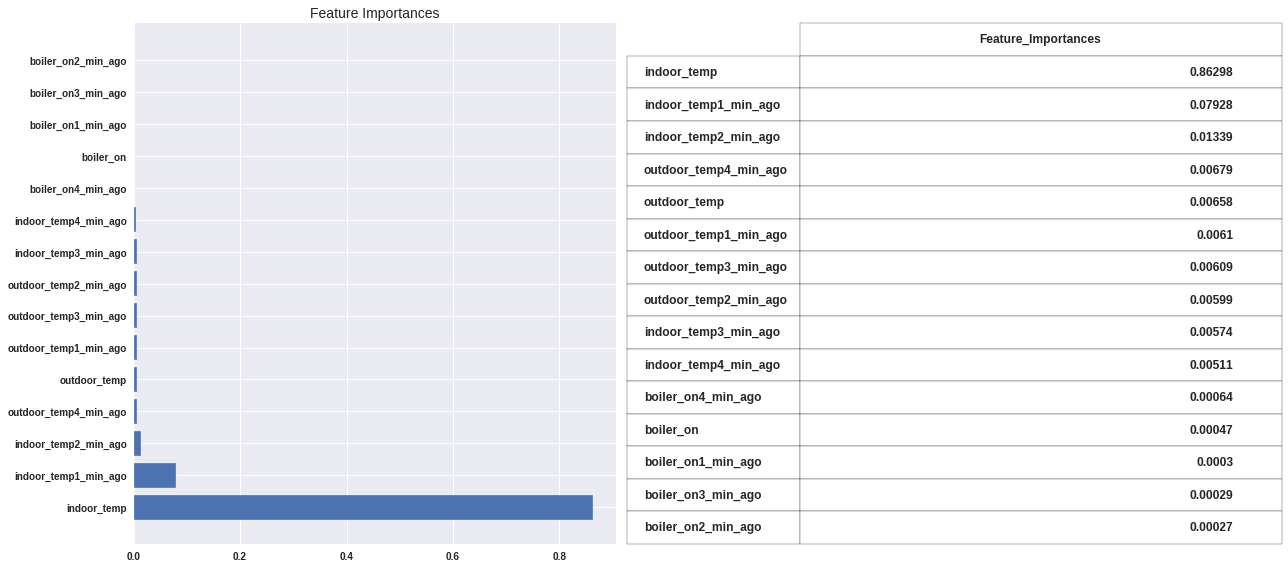

In [42]:
rf_reg_10min = RandomForestRegressor(criterion='mse',
                               random_state=123)
scaler = MinMaxScaler()

regression_modeling(rf_reg_10min, scaler, 'Random Forest Regression - 10 Minutes -')

### ***Observations***

*   We create a new dataset using differencing with period 1.


*   This model is designed to predict temperature difference 10 minutes into the future.

*   We apply Random Forest Regressor with MinMaxScaler.

*   The MSE is 0.09, Train Score is 0.99 and Test Scoreis 0.92.  are the same as Ramdom Forest modeling with differencing 1 and 5 minutes into the future. 

*   The MSE for predicting 5 minutes into the future is  0.12.

*   We observe that predicting the next 10 minute provides better MSE.

## Predicting 5 Minute Out

In [43]:
ts = pd.concat([ts[['outdoor_temp', 'indoor_temp']].diff(periods=1), ts[['boiler_on']]], axis=1)
ts.dropna(inplace=True)

In [44]:
temp = ts[['indoor_temp']]
ts_shift = temp.shift(periods=-5)
ts_shift = ts_shift.rename(columns={'indoor_temp':'shifted_temp'})

ts_new = pd.concat([ts, ts_shift], axis=1)
ts_new.dropna(inplace=True)
ts_new.head()
ts_new['temp_diff'] = ts_new['shifted_temp'] - ts_new['indoor_temp']

ts_diff = ts_new[ts_new['temp_diff'] != 0]
ts_diff.head(10)

,outdoor_temp,indoor_temp,boiler_on,shifted_temp,temp_diff
ts,,,,,
2020-11-17 20:29:00,0.744,0.000,0.0,0.2240,0.2240
2020-11-17 20:30:00,-2.092,0.000,0.0,-0.0560,-0.0560
2020-11-17 20:31:00,1.257,-0.056,0.0,0.0000,0.0560
2020-11-17 20:32:00,0.876,0.224,0.0,0.0000,-0.2240
2020-11-17 20:33:00,-0.953,-0.336,0.0,0.0000,0.3360
2020-11-17 20:34:00,-0.790,0.224,0.0,0.0000,-0.2240
2020-11-17 20:35:00,1.239,-0.056,0.0,0.0000,0.0560
2020-11-17 20:40:00,0.650,0.000,0.0,-1.5705,-1.5705
2020-11-17 20:41:00,-0.333,0.000,0.0,6.2820,6.2820


In [45]:
columns = ['indoor_temp', 'outdoor_temp', 'boiler_on']

for col in columns:
    for i in range(1,10):
        ts_diff[col+str(i)+'_min_ago'] = ts_diff[col].shift(i)
ts_diff.dropna(inplace=True)
ts_diff.head()

,outdoor_temp,indoor_temp,boiler_on,shifted_temp,temp_diff,indoor_temp1_min_ago,indoor_temp2_min_ago,indoor_temp3_min_ago,indoor_temp4_min_ago,indoor_temp5_min_ago,indoor_temp6_min_ago,indoor_temp7_min_ago,indoor_temp8_min_ago,indoor_temp9_min_ago,outdoor_temp1_min_ago,outdoor_temp2_min_ago,outdoor_temp3_min_ago,outdoor_temp4_min_ago,outdoor_temp5_min_ago,outdoor_temp6_min_ago,outdoor_temp7_min_ago,outdoor_temp8_min_ago,outdoor_temp9_min_ago,boiler_on1_min_ago,boiler_on2_min_ago,boiler_on3_min_ago,boiler_on4_min_ago,boiler_on5_min_ago,boiler_on6_min_ago,boiler_on7_min_ago,boiler_on8_min_ago,boiler_on9_min_ago
ts,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-17 20:42:00,0.266,0.0000,0.0,-9.4230,-9.4230,0.0000,0.0,-0.056,0.224,-0.336,0.224,-0.056,0.000,0.000,-0.333,0.650,1.239,-0.790,-0.953,0.876,1.257,-2.092,0.744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-17 20:43:00,-0.815,0.0000,0.0,6.2820,6.2820,0.0000,0.0,0.000,-0.056,0.224,-0.336,0.224,-0.056,0.000,0.266,-0.333,0.650,1.239,-0.790,-0.953,0.876,1.257,-2.092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-17 20:44:00,0.926,0.0000,0.0,-1.5705,-1.5705,0.0000,0.0,0.000,0.000,-0.056,0.224,-0.336,0.224,-0.056,-0.815,0.266,-0.333,0.650,1.239,-0.790,-0.953,0.876,1.257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-17 20:45:00,-0.479,-1.5705,0.0,-0.5625,1.0080,0.0000,0.0,0.000,0.000,0.000,-0.056,0.224,-0.336,0.224,0.926,-0.815,0.266,-0.333,0.650,1.239,-0.790,-0.953,0.876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-17 20:46:00,0.354,6.2820,0.0,2.1935,-4.0885,-1.5705,0.0,0.000,0.000,0.000,0.000,-0.056,0.224,-0.336,-0.479,0.926,-0.815,0.266,-0.333,0.650,1.239,-0.790,-0.953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# Create target
y = ts_diff[['temp_diff']]

# Create predictors
X = ts_diff.drop(['shifted_temp', 'temp_diff'], axis=1)
X.head()

,outdoor_temp,indoor_temp,boiler_on,indoor_temp1_min_ago,indoor_temp2_min_ago,indoor_temp3_min_ago,indoor_temp4_min_ago,indoor_temp5_min_ago,indoor_temp6_min_ago,indoor_temp7_min_ago,indoor_temp8_min_ago,indoor_temp9_min_ago,outdoor_temp1_min_ago,outdoor_temp2_min_ago,outdoor_temp3_min_ago,outdoor_temp4_min_ago,outdoor_temp5_min_ago,outdoor_temp6_min_ago,outdoor_temp7_min_ago,outdoor_temp8_min_ago,outdoor_temp9_min_ago,boiler_on1_min_ago,boiler_on2_min_ago,boiler_on3_min_ago,boiler_on4_min_ago,boiler_on5_min_ago,boiler_on6_min_ago,boiler_on7_min_ago,boiler_on8_min_ago,boiler_on9_min_ago
ts,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-17 20:42:00,0.266,0.0000,0.0,0.0000,0.0,-0.056,0.224,-0.336,0.224,-0.056,0.000,0.000,-0.333,0.650,1.239,-0.790,-0.953,0.876,1.257,-2.092,0.744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-17 20:43:00,-0.815,0.0000,0.0,0.0000,0.0,0.000,-0.056,0.224,-0.336,0.224,-0.056,0.000,0.266,-0.333,0.650,1.239,-0.790,-0.953,0.876,1.257,-2.092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-17 20:44:00,0.926,0.0000,0.0,0.0000,0.0,0.000,0.000,-0.056,0.224,-0.336,0.224,-0.056,-0.815,0.266,-0.333,0.650,1.239,-0.790,-0.953,0.876,1.257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-17 20:45:00,-0.479,-1.5705,0.0,0.0000,0.0,0.000,0.000,0.000,-0.056,0.224,-0.336,0.224,0.926,-0.815,0.266,-0.333,0.650,1.239,-0.790,-0.953,0.876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-17 20:46:00,0.354,6.2820,0.0,-1.5705,0.0,0.000,0.000,0.000,0.000,-0.056,0.224,-0.336,-0.479,0.926,-0.815,0.266,-0.333,0.650,1.239,-0.790,-0.953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(951587, 30) (407824, 30) (951587, 1) (407824, 1)


Train Score :  0.92714
Test Score  :  0.48786 

Random Forest Regression - 5 Minutes - Mean Squared Error :  2.78079





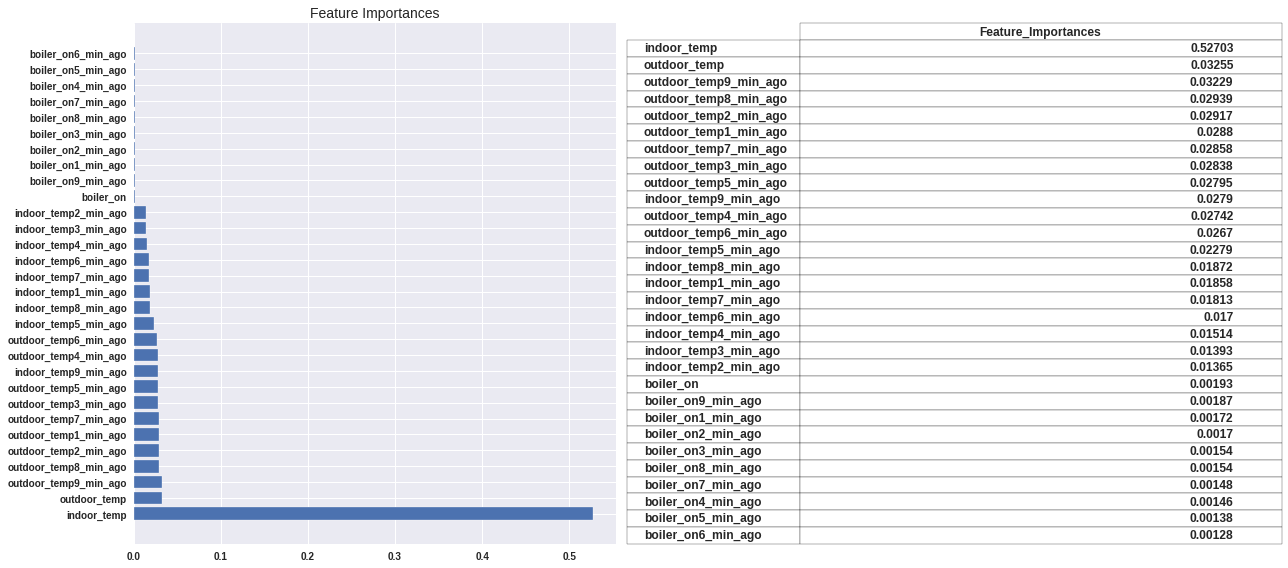

In [48]:
rf_reg_5min = RandomForestRegressor(criterion='mse',
                               random_state=123)
scaler = MinMaxScaler()

regression_modeling(rf_reg_5min, scaler, 'Random Forest Regression - 5 Minutes -')

### ***Observations***

*   We create a new dataset using differencing with period 1 and used 10 minutes of data for each row.

*   This model is designed to predict temperature difference 5 minutes into the future.

*   We apply Random Forest Regressor with MinMaxScaler.

*   The MSE is 2.79, Train Score is 0.93 and Test Score is 0.49.

*   Indoor temperature - 0 minutes ago is significantly effective on the model.

*   5 minute time frame has better results as predictors.

# CONCLUSION

*   We have been predicting indoor temperature in the next 5th minute. We created fairly accurate models. For model tuning, first we stripped our data where there is no indoor temperature change within the next 5 minutes. 

*   We applied 4 of more prominent regression models including Decision Trees, Random Forest, Extra Trees and Gradient Boosting. Later, we tuned the most promising 2 base models with different parameters. Some base models are more open to improvement. As we observed our Extra Trees Regression Model have better base results compared to Random Forest Regression. We apply different methods for tuning and receive better results with Random Forest Regression.


*   With Random Regressor, we received better results when using MinMaxScaler instead of StandardScaler as our standardization method. All our Random Forest Regressions are standardized with MinMaxScaler. 

*   In all the models, we observe *indoor_temp* columns are the most significant columns, mostly the first and/or the last indoor temperature values. *outdoor_temp* columns are also has a good feature importance at some models. It seems *boiler_on* is the least significant predictor. In practice, it is safe to say it plays a major role on the next indoor temperature value.

*   Below, you see Train-Test Scores and MSE Values for differently tuned models. Our base model is predicting the difference with the next 5th minute using indoor_temp, outdoor_temp and boiler_on columns and their previous 4 minutes' data. (Each row has 5 minutes' data) Our MSE is 0.135. Our goal is to improve this model, and get smaller MSE.

*   **Tuning with Differencing with Periods=5** : We apply differencing to indoor and outdoor temperature columns with periods=5. Our MSE is improved 0.005.

*   **Tuning with Differencing with Periods=1** : We apply differencing to indoor and outdoor temperature columns with periods=1. Our MSE is 0.12. We observe that we receive better results with differencing 1 and will use this in the next models.


*   **Tuning with Differencing with Periods=1 to Predict 1 Minute Out** : In this model, we change our target to predict the indoor temperature difference with the next minute's temperature. We get a MSE of 0.085 which is highly improved compared to the base.

*   **Tuning with Differencing with Periods=1 to Predict 10 Minute Out** : In this model, we change our target to predict the indoor temperature difference with the next 10th minute's temperature. We get a MSE of 0.09. This is an interesting finding. Because the model proved it is better predicting the next model. One would think predicting the next 5th minute will provide better results than predicting the next 10th minute. 

*   **Tuning with Differencing with Periods=1 to Predict 5 Minute Out with 10 Minute Worth of Predictors** : For this model we change the number of predictors. Instead of using 5 minutes worth of data(15 predictors), we use 10 minutes data(30 predictors). This is another interesting result that this model has the worst Mean Squared Error Value. When initiating this model, my Null Hypothesis was reading the last 5 minutes data to predict the next 5th minute's difference will provide better results thatn reading the last 10 minutes data. With this model we prove that we fail to reject the Null Hypothesis.

*   Of all the tuned models, we get the best results with differencing the data with periods=1 using 5 minutes' data as predictors. Both predicting 1 minute and 10 minute out provide prominent results.

In [10]:
model_index = ['5 Min-Random Forest Base', '5 Min-Diff Period=5/5Preds', 
               '5 Min-Diff Period=1/5Preds', '1 Min-Diff Period=1/5Preds', 
               '10 Min-Diff Period=1/5Preds', '5 Min-Diff Period=1/10Preds' ]

train_scores = [0.909, 0.945, 0.930, 0.990, 0.991, 0.930]
test_scores = [0.360, 0.662, 0.530, 0.931, 0.926, 0.490]
mse_values = [0.135, 0.130, 0.12, 0.085, 0.090, 2.79]

model_df = pd.DataFrame()
model_df['train_score'] = train_scores
model_df['test_score'] = test_scores
model_df['mse_values'] = mse_values
model_df.index = model_index
model_df

,train_score,test_score,mse_values
5 Min-Random Forest Base,0.909,0.360,0.135
5 Min-Diff Period=5/5Preds,0.945,0.662,0.130
5 Min-Diff Period=1/5Preds,0.930,0.530,0.120
1 Min-Diff Period=1/5Preds,0.990,0.931,0.085
10 Min-Diff Period=1/5Preds,0.991,0.926,0.090
5 Min-Diff Period=1/10Preds,0.930,0.490,2.790


# SUGGESTION

*   We have very limited predictors. We can start feature engineering in order to create better predictors. One feature can be creating a columns where we store how many consecutive minutes the boiler has been on or off. This may improve the level of feature importance of *boiler_on* column. 

*   Another options is checking for non-linearities in the relationship between outdoor temperature and the change in indoor temperature.

*   We observed that temperature does not change from minute to minute very often. So when we are using the previous minutes data, most of the time we have the same values. We can change the frequency of our time series such as 5 minutes(5T). In practice, this will increase the variety in predictor values. 

*   Use TensorFlow to do modeling using Time Series.